# Time series clustering

The goal of this project is to explore methods and distance metrics for time series clustering and to compare them.

In [1]:
# import of libraries we will use
%matplotlib inline
import random
from math import sqrt, log, floor
from dtw import dtw
from fastdtw import fastdtw
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, mean_squared_error

sns.set(style='white')

Our dataset comprises of around 200 multidimensional timeseries. Each serie contains measurements taken by 23 sensors.

In [2]:
# load data
data = pd.read_csv('data/train.txt', header=None, delim_whitespace=True)
# data normalization
for column in range(2, 26):
    data[column] = (data[column] - data[column].mean()) / data[column].std()
data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.946633,-1.032857,-0.897512,0.611799,0.656125,0.747996,0.872271,0.686528,...,0.768702,0.420043,0.650642,-0.945465,1.407503,0.707894,0.622245,0.419839,0.787906,0.792200
1,1,2,-1.622814,-1.836240,1.563749,1.731217,1.672411,1.548658,1.658630,1.816899,...,1.851910,0.420198,0.792348,-1.252581,1.407503,1.534115,1.095841,0.419839,1.839028,1.833676
2,1,3,0.742866,0.864646,0.333118,-0.885167,-0.646592,-0.487151,-0.695764,-0.703003,...,-0.598445,0.418641,-0.020112,0.030947,-0.710463,-0.513475,-0.036670,0.419839,-0.600465,-0.607676
3,1,4,-0.270777,0.415677,-1.512828,0.692676,0.733684,0.644408,0.363952,0.363958,...,0.353904,0.419576,-0.155934,-0.145421,-0.710463,0.564204,0.656564,0.419839,0.367860,0.389925
4,1,5,1.216413,0.865932,-0.282197,-1.052966,-0.804384,-0.615953,-0.680456,-1.135852,...,-0.980745,0.418174,0.213280,-0.045000,-0.710463,-0.657166,-0.112171,0.419839,-0.988199,-1.020503


## Data exploration
Average length of the serie is around 210 timesteps. Minimial length is 128 time steps and the maximum is 357 timesteps.

In [3]:
data[0].value_counts().describe()

count    218.000000
mean     210.633028
std       43.595578
min      128.000000
25%      177.000000
50%      209.500000
75%      236.000000
max      357.000000
Name: 0, dtype: float64

Let us look at a single timeserie and the readings from all the sensors in a single plot.

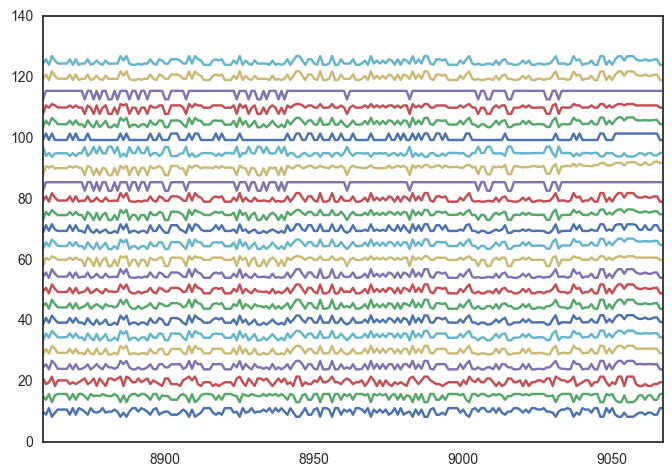

In [4]:
serie = data[data[0]==43]
for i in range(2, 26):
    (serie[i]+5*i).plot(x=1)

We see that many sensors measure similar things and there is a lot of noise.

## Whole timeseries clustering

At first we tried to cluster whole time series. In order to evaluate results of different clustering algorithms we generated training set with ground truth labels by cutting tail of random length from each timeserie. The label for a serie is then the length of the cut tail. We tried K-means and HAC clustering algorithms with eucledean distance and DTW. Evaluation using normalized mutual information and adjusted rand index has shown poor performance. We attribute these results to significant noise in the data and the fact that the series are of very different lengths. This has lead to our second approach, clustering only chunks of series.

## Chunk clustering

The idea is to cut series into disjoint chunks of equal length and assign them labels based on the distance from the end of the serie.

In [5]:
# group data by each timeserie
grouped = data.groupby(0)
series = [group.drop(labels=[0,1], axis=1) for name, group in grouped]
# number of clusters
k = 6
# length of chunks
chunk_length = 10
# go through groups and compute chunks and labels
train_set = []
true_labels = []
for serie in series:
    reversed_serie = serie.iloc[::-1]
    for i in range(len(serie) // chunk_length):        
        chunk = reversed_serie[i*10:(i+1)*10]
        true_label = i
        train_set.append(chunk)
        true_labels.append(true_label)

Some algorithms were incredibly slow, so we sampled just a subset of chunks to run algorithms on.

In [6]:
# sampling
n = 100
indices = random.sample(list(range(len(train_set))), k=n) 
sample = [train_set[i] for i in indices]
sample_labels = [true_labels[i] for i in indices]

### Distance computations

For computing distances between chunks we tried 4 distance metrics, Eucledean distance, RMS, DTW and Longest common subsequence. As the chunks are of the same length, RMS is just a scaled version of Eucledean distance resulting in the very similiar or identical clusters. Computations of Eucledean distance and RMS are quite fast while DTW runs a bit slower and LCSS was the slowest. It would take upwards of an hour when computing distances of every pair of chunks.

In [7]:
# compute eucledean distance
euclidean_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        euclidean_distances[i,j] = euclidean(sample[i].values.flatten(), sample[j].values.flatten())

In [8]:
# compute distances using RMSE
rmse_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        rmse_distances[i,j] = sqrt(mean_squared_error(sample[i].values.flatten(), sample[j].values.flatten()))

In [9]:
# compute distances using DTW
def dtw(x, y):
    dist, _ = fastdtw(x, y, dist=euclidean)
    return dist

dtw_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dtw_distances[i,j] = dtw(sample[i], sample[j])

In [10]:
# compute distances using LCSS

# function for LCSS computation
# based on implementation from https://rosettacode.org/wiki/Longest_common_subsequence
def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

lcs_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        lcs_distances[i,j] = multidim_lcs(sample[i], sample[j])

In the figure below, there is a heatmap of LCSS distances between sampled chunks.

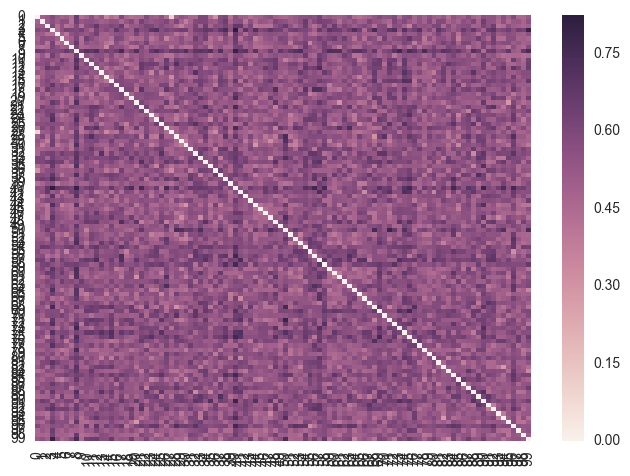

In [11]:
sns.heatmap(lcs_distances)

## Clustering algorithms

For each of these four metrics we have tried two clustering algorithms, K-means and Hierarchical agglomerative clustering.

In [12]:
k = 6
y_pred_km_euc = KMeans(n_clusters=k).fit_predict(euclidean_distances)
y_pred_km_dtw = KMeans(n_clusters=k).fit_predict(dtw_distances)
y_pred_km_rmse = KMeans(n_clusters=k).fit_predict(rmse_distances)
y_pred_km_lcs = KMeans(n_clusters=k).fit_predict(lcs_distances)

In [13]:
y_pred_hac_euc = AgglomerativeClustering(n_clusters=k).fit_predict(euclidean_distances)
y_pred_hac_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_distances)
y_pred_hac_rmse = AgglomerativeClustering(n_clusters=k).fit_predict(rmse_distances)
y_pred_hac_lcs = AgglomerativeClustering(n_clusters=k).fit_predict(lcs_distances)

## Evaluation

In [14]:
# True label normalisation
log_base = max(true_labels)**(1 / k) + 0.05
normalised_true_labels = [floor(log(l+1, log_base)) for l in sample_labels]

In [15]:
print('Normalized Mutual Information')
print('K-means + Eucledean: ', normalized_mutual_info_score(normalised_true_labels, y_pred_km_euc))
print('K-means + RMS:       ', normalized_mutual_info_score(normalised_true_labels, y_pred_km_rmse))
print('K-means + DTW:       ', normalized_mutual_info_score(normalised_true_labels, y_pred_km_dtw))
print('K-means + LCSS:      ', normalized_mutual_info_score(normalised_true_labels, y_pred_km_lcs))
print('HAC + Eucledean:     ', normalized_mutual_info_score(normalised_true_labels, y_pred_hac_euc))
print('HAC + RMS:           ', normalized_mutual_info_score(normalised_true_labels, y_pred_hac_rmse))
print('HAC + DTW:           ', normalized_mutual_info_score(normalised_true_labels, y_pred_hac_dtw))
print('HAC + LCSS:          ', normalized_mutual_info_score(normalised_true_labels, y_pred_hac_lcs))

Normalized Mutual Information
K-means + Eucledean:  0.0990753643599
K-means + RMS:        0.0866702162061
K-means + DTW:        0.0819233619403
K-means + LCSS:       0.229044719945
HAC + Eucledean:      0.0803436904602
HAC + RMS:            0.0803436904602
HAC + DTW:            0.0681733036618
HAC + LCSS:           0.191950775666


In [22]:
print('Adjusted Rand Index')
print('K-means + Eucledean:  ', adjusted_rand_score(normalised_true_labels, y_pred_km_euc))
print('K-means + RMS:       ', adjusted_rand_score(normalised_true_labels, y_pred_km_rmse))
print('K-means + DTW:       ', adjusted_rand_score(normalised_true_labels, y_pred_km_dtw))
print('K-means + LCSS:       ', adjusted_rand_score(normalised_true_labels, y_pred_km_lcs))
print('HAC + Eucledean:     ', adjusted_rand_score(normalised_true_labels, y_pred_hac_euc))
print('HAC + RMS:           ', adjusted_rand_score(normalised_true_labels, y_pred_hac_rmse))
print('HAC + DTW:           ', adjusted_rand_score(normalised_true_labels, y_pred_hac_dtw))
print('HAC + LCSS:           ', adjusted_rand_score(normalised_true_labels, y_pred_hac_lcs))

Adjusted Rand Index
K-means + Eucledean:   0.00996046697306
K-means + RMS:        -0.00937086801231
K-means + DTW:        -0.0139991406585
K-means + LCSS:        0.0875449574853
HAC + Eucledean:      -0.0142977623147
HAC + RMS:            -0.0142977623147
HAC + DTW:            -0.0174612858171
HAC + LCSS:            0.0754488052663


The best results have been achieved using LCSS distances. The choice of clustering algorithm has not played a significant role.

## Cluster visualisation

We tried to take a deeper look at clusters detected by HAC with LCSS. We first tried plotting all the clusters using PCA. The chunks from the same cluster are placed in close proximity to each other. This has led us to look deeper how clusters relate to each sensor readings.

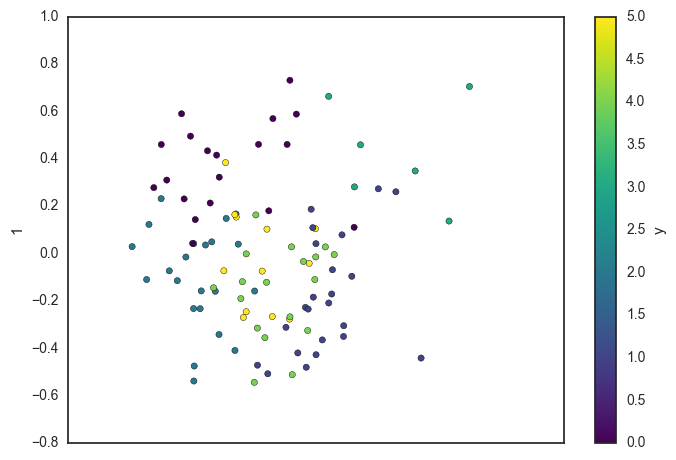

In [17]:
pca = PCA(n_components=2)
emb = pd.DataFrame(pca.fit_transform(lcs_distances))
emb['y'] = y_pred_hac_lcs
emb['gt'] = normalised_true_labels
emb.plot(kind='scatter', x=0, y=1, c='y', cmap='viridis')

In [18]:
# computeting features for a single chunk and sensor
def extract_featrues(chunk, s):
    column = chunk[s]
    slope = (column.iloc[-1]-column.iloc[0])/10
    return (column.std(), column.mean(), slope)

def compute_features_for_all_chunks(s):
    stds = []
    means = []
    slopes = []

    for chunk in sample:
        std, mean, slope = extract_featrues(chunk, s)
        stds.append(std)
        means.append(mean)
        slopes.append(slope)
    return pd.DataFrame({'std': stds, 'mean': means, 'slope': slopes, 'true_label': normalised_true_labels, 'cluster': y_pred_hac_lcs})

Below can be seen scatter plots for every sensor (rows) and for different pairs of features (mean x std, mean x slope, slope x std ) (columns).

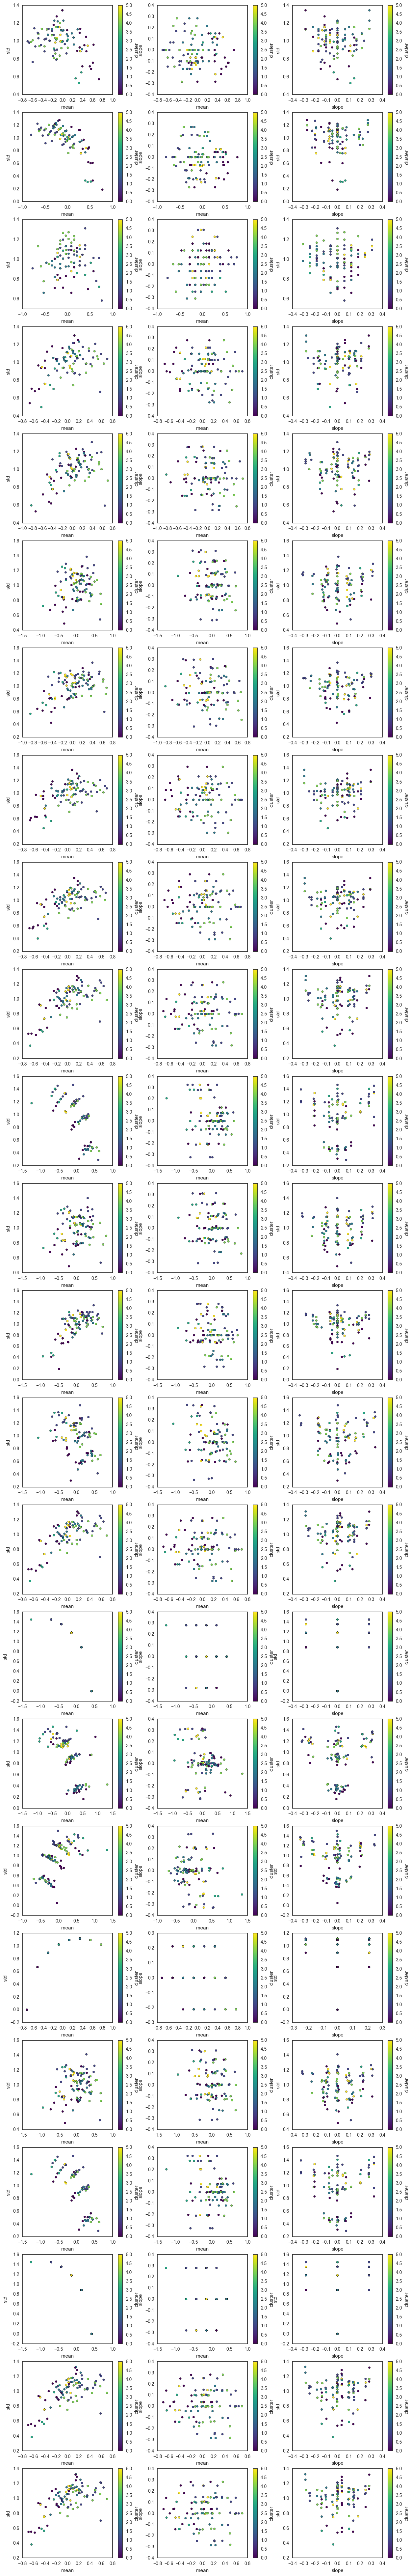

In [19]:
sensor_max = 25
sensor_min = 2

f, axis = plt.subplots(sensor_max-sensor_min+1, 3, figsize=(15,100))
for s in range(sensor_min, sensor_max+1):
    features = compute_features_for_all_chunks(s)
    features.plot(kind='scatter', x='mean', y='std', c='cluster', cmap='viridis', ax=axis[s-sensor_min][0])
    features.plot(kind='scatter', x='mean', y='slope', c='cluster', cmap='viridis', ax=axis[s-sensor_min][1])
    features.plot(kind='scatter', x='slope', y='std', c='cluster', cmap='viridis', ax=axis[s-sensor_min][2])

Some sensors reveal interesting information. For example, sensor 22 that can be also seen below (left). We can see that combination of mean and standard deviation separate chunks into 5 distinct clusters. However, these clusters are different from those detected by the algortihm (and also from the ground truth).

On the other hand on sensor 4 there are no visually distinct culsters. But we can see a bit of gradient going from bottom right to top left with the lowest cluster number in the bottow right.

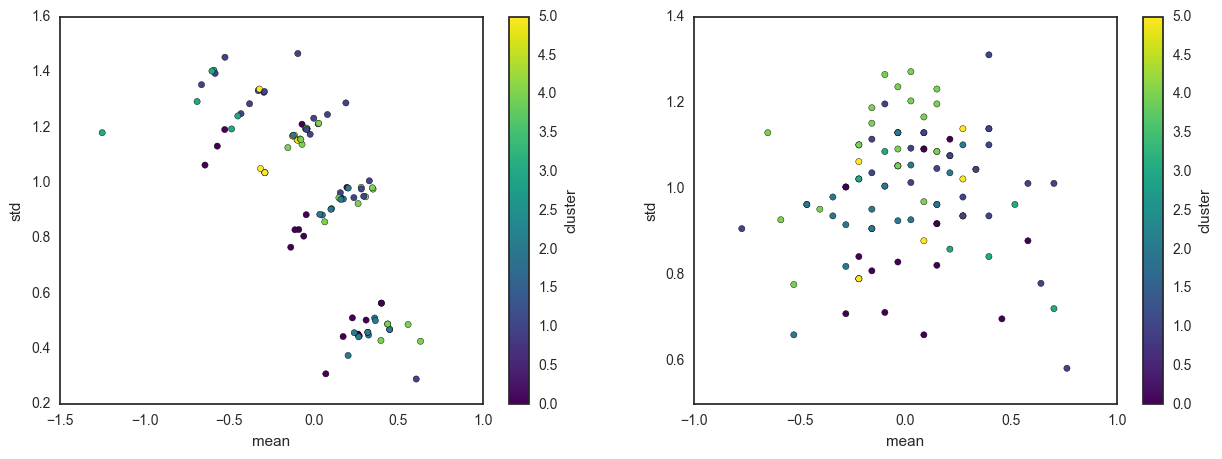

In [23]:
# sensors 22 and 4
# mean x std
f, axis = plt.subplots(1, 2, figsize=(15,5))
features = compute_features_for_all_chunks(22)
features.plot(kind='scatter', x='mean', y='std', c='cluster', cmap='viridis', ax=axis[0])
features = compute_features_for_all_chunks(4)
features.plot(kind='scatter', x='mean', y='std', c='cluster', cmap='viridis', ax=axis[1])

We furter explored what these features correspond to in the raw data. Below, we have plotted chunks for each of the six clusters. For example in the second cluster, we can see that most of the chunks start high and end with quite lower value while in the third cluster the behaviour is opposite. Some clusters, for example 4th and 5th, have significantly lower standard deviation than the others.

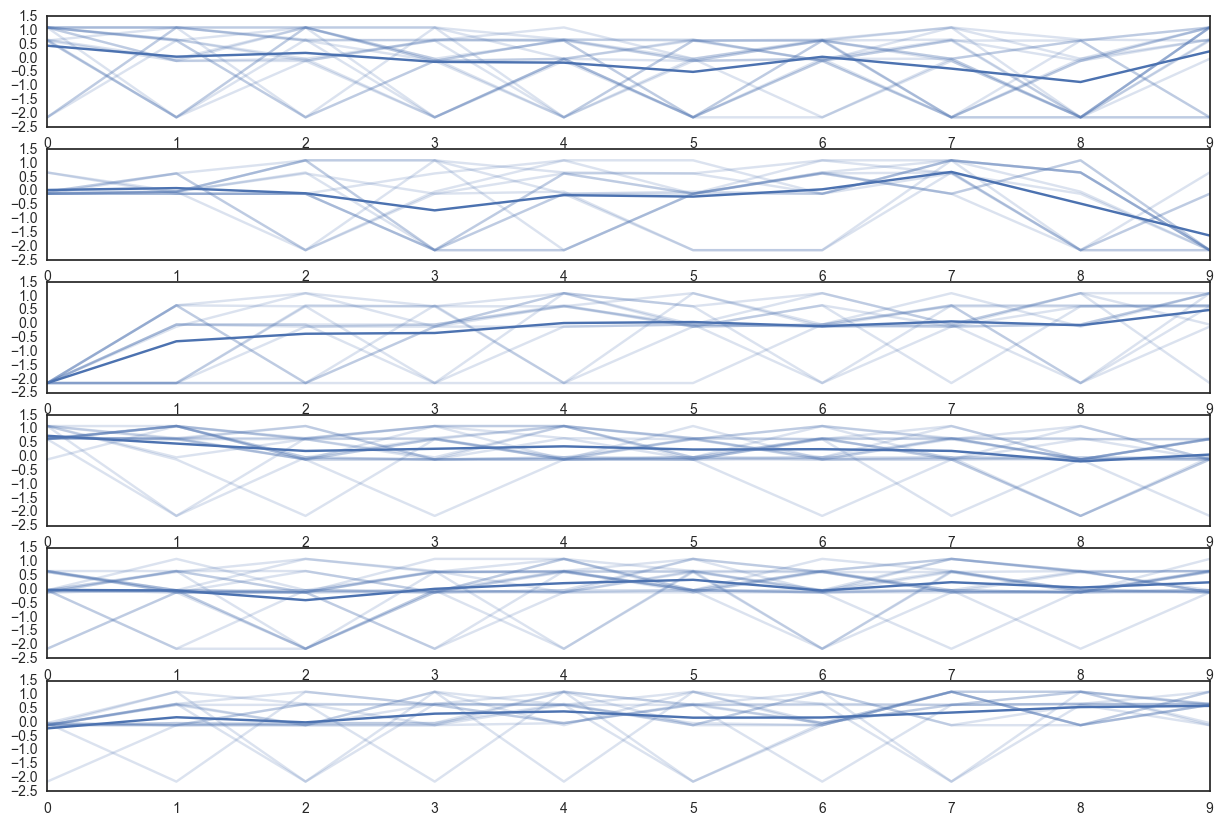

In [21]:
num_cluster = len(set(y_pred_hac_lcs))
sensor = 22

f, axis = plt.subplots(num_cluster, 1, figsize=(15, 10))
for c in range(num_cluster):
    index = y_pred_hac_dtw == c
    cluster_chunks = pd.DataFrame([chunk[sensor].reset_index(drop=True) for chunk, flag in zip(sample, index) if flag]).as_matrix()
    sns.tsplot(data=cluster_chunks, err_style='unit_traces', ax=axis[c])

To sum up, for this type of sensor data that we worked with, we found out that LCSS distances were by far the best. The computation of these distances was slow. This could be probably optimized a bit with better implementation.

There are some patterns that can be seen in the data which can be used to cluster the chunks. However, it is not clear if these features can be used for predicting how far the chunk is form the end of the time serie as the evaluation metrics show poor results.